In [1]:
import h5py, sys, os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from scipy import interpolate
from datetime import datetime
from os.path import join
print(os.getcwd())

%matplotlib ipympl

vapour = True

from jfunctions import *

base_dir = '/store/ATMOS/cwp29/data/moisture/'
dir = 'moist_exp/old'
simulations = ['q0_5_phis_001', 'q0_2_phis_002', 'q0_02_phis_01']
res = '512'

tplot = 20

def hydration_profile(phibins, Wv):
    dphi = phibins[1] - phibins[0]
    return phibins * np.nansum(Wv*db*dphi, axis=1)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/moisture


q0_5_phis_001
Mean keys: <KeysViewHDF5 ['FTx_uu', 'PVD_bbins', 'PVD_phicbins', 'PVD_phipbins', 'PVD_phivbins', 'b_phic_F1_vol', 'b_phic_F3_vol', 'b_phic_Jc_vol', 'b_phic_K_vol', 'b_phip_F1_vol', 'b_phip_F4_vol', 'b_phiv_F1_vol', 'b_phiv_F2_vol', 'b_phiv_Jv_vol', 'cp', 'dthdz01', 'dthdz02', 'dthdz03', 'dthdz04', 'dudz', 'dvdz', 'eps_sgs1', 'eps_sgs2', 'epsilon', 'gzf', 'kappa1_net', 'kappa2_net', 'kappa3_net', 'kappa4_net', 'kappa_sgs', 'mke', 'nu_sgs', 'omega_x', 'omega_y', 'omega_z', 'pe_diss01', 'pe_diss02', 'pe_diss03', 'pe_diss04', 'shear', 'tb_source', 'tb_source_bins', 'tb_strat', 'tb_strat_bins', 'td_scatter_vol', 'thme01', 'thme02', 'thme03', 'thme04', 'thrms01', 'thrms02', 'thrms03', 'thrms04', 'thw01', 'thw01_m', 'thw02', 'thw02_m', 'thw03', 'thw03_m', 'thw04', 'thw04_m', 'time', 'u1z_x0', 'ume', 'urms', 'uu_dudx', 'uv', 'uw', 'uw_dudz', 'vme', 'vrms', 'vu_dvdx', 'vw_dvdz', 'wme', 'wrms', 'wu_dwdx', 'wv', 'ww_dwdz']>
Plume penetration occured at t=4.2607
1.565890168740143e-08


KeyboardInterrupt



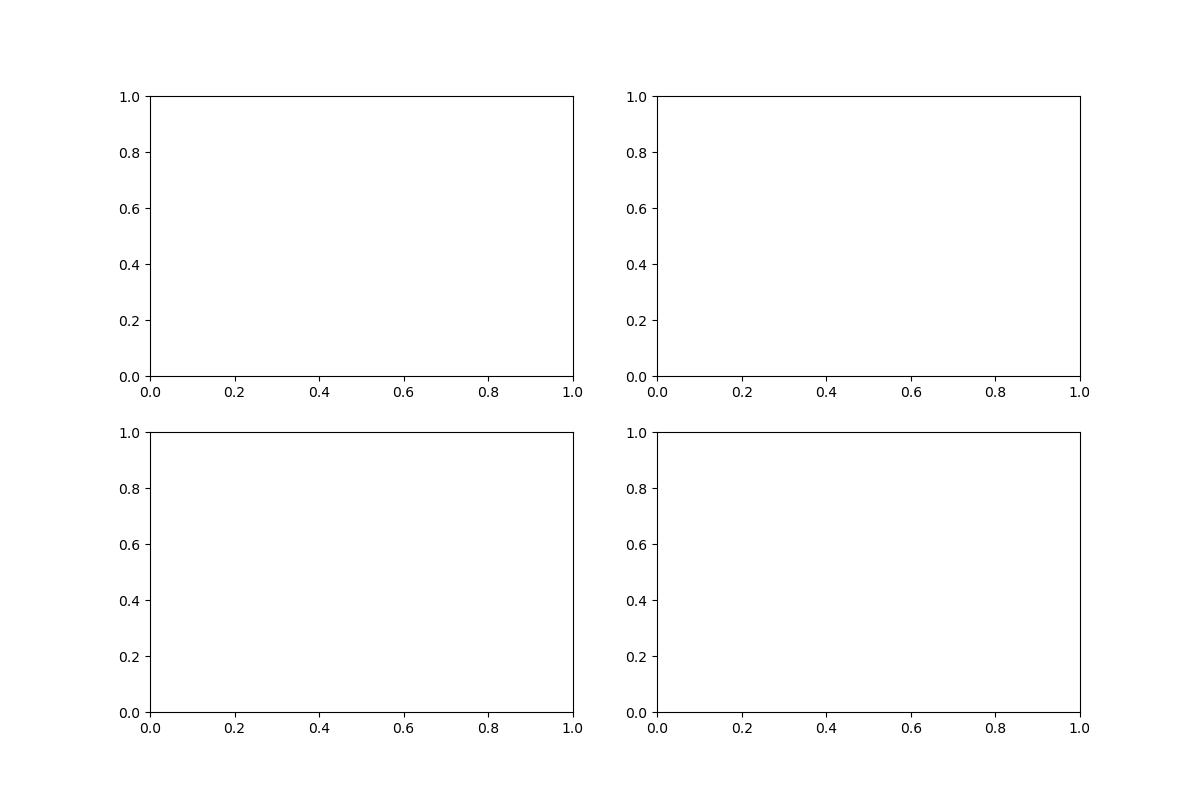

In [2]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
cols = plt.cm.cool(np.linspace(0,1,len(simulations)))

for d in range(len(simulations)):
    print(simulations[d])
    save_dir = join(base_dir, dir, simulations[d], res)
    
    # Load simulation metadata
    md = get_metadata(run_dir=save_dir, version="3.12")
    
    #Load simulation data
    Wv, Wc, Wp, Sv_cum, Sc_cum, Sp_cum, times = load_data('b_phiv_W', 'b_phic_W', 'b_phip_W', 'b_phiv_S', 'b_phic_S', 'b_phip_S', save_dir=save_dir, verbose=False)
    
    NSAMP = len(times)

    bbins, phivbins = load_bins_moist(save_dir, True, verbose=False)
    bbins, phicbins = load_bins_moist(save_dir, False, verbose=False)
    bbins, phipbins = load_bins(save_dir, 'PVD_bbins', 'PVD_phipbins')
    
    db = bbins[1] - bbins[0]
    dphi_v = phivbins[1] - phivbins[0]
    dphi_c = phicbins[1] - phicbins[0]
    dphi_p = phipbins[1] - phipbins[0]

    times, t0_idx = calibrate_time(save_dir, times)
    
    # Set-up
    Wv = np.where(Wv == 0, np.NaN, Wv)
    Wc = np.where(Wc == 0, np.NaN, Wc)
    Wp = np.where(Wp == 0, np.NaN, Wp)

    F0 = compute_F0(save_dir, md, tstart_ind = 2*4, verbose=False, zbot=0.7, ztop=0.95, plot=False, moist=False, tracer=True)
    # need to change zbot and ztop, to (more) accurately measure F0. Maybe use phi_p to measure this?
    print(F0)
    
    for i in range(1, NSAMP):
        Sc_cum[i] += Sc_cum[i-1]
        Sv_cum[i] += Sv_cum[i-1]
        Sp_cum[i] += Sp_cum[i-1]
        
    Sc_cum = np.where(Sc_cum == 0, np.NaN, Sc_cum)
    Sp_cum = np.where(Sp_cum == 0, np.NaN, Sp_cum)
    Sv_cum = np.where(Sv_cum == 0, np.NaN, Sv_cum)
    
    b_az, phiv_az, phic_az, phip_az = load_az_data('b_az', 'phiv_az', 'phic_az', 'phip_az', save_dir=save_dir, verbose=False)
    gxf, gyf, gzf, dzf = get_grid(md, save_dir=save_dir)
    
    z_pen = md['H']

    phip_postpen = phip_az[np.logical_and(times > 0, times < md['T']), :, :]
    b_postpen = b_az[np.logical_and(times > 0, times < md['T']), :, :]

    phip_pen = np.mean(phip_postpen[:, get_index(gzf, z_pen), 0])
    b_pen = np.mean(b_postpen[:, get_index(gzf, z_pen), 0])

    phi_vs_pen = md['q0']*np.exp(md['alpha']*(b_pen - md['beta']*z_pen))

    sat_param = phip_pen / phi_vs_pen

    hv = hydration_profile(phivbins, Wv)
    hc = hydration_profile(phicbins, Wc)
    hp = hydration_profile(phipbins, Wp)

    T_v = np.nansum(Sv_cum*db*dphi_v*phivbins, axis=(1,2))
    T_c = np.nansum(Sc_cum*db*dphi_c*phicbins, axis=(1,2))
    T_p = np.nansum(Sp_cum*db*dphi_p*phipbins, axis=(1,2))

    tplot_idx = get_index(tplot, times)

    axs[0,0].plot(bbins, hv[tplot_idx]/T_v[tplot_idx], color=cols[d], label="RH = {0:.2f}, vapour".format(sat_param))
    axs[0,0].plot(bbins, hc[tplot_idx]/T_c[tplot_idx], color=cols[d], linestyle='--', label="RH = {0:.2f}, condensate".format(sat_param))
    
    axs[0,1].plot(bbins, hv[tplot_idx]/T_v[tplot_idx] - hp[tplot_idx]/T_p[tplot_idx], color=cols[d], label=round(sat_param,2))

    if d == 0:
        axs[1,0].plot(times, T_v, color=cols[d], label=r"$T_c(t)$")
        axs[1,0].plot(times, T_c, color=cols[d], label=r"$T_v(t)$", linestyle='--')
        axs[1,0].plot(times, T_c+T_v, color=cols[d], label=r"$T_v(t) + T_c(t)$", linestyle='-.')
        axs[1,0].plot(times, T_p, color=cols[d], label=r"$T_p(t)$", linestyle=':')
    else:
        axs[1,0].plot(times, T_v, color=cols[d])
        axs[1,0].plot(times, T_c, color=cols[d], linestyle='--')
        axs[1,0].plot(times, T_c+T_v, color=cols[d], linestyle='-.')
        axs[1,0].plot(times, T_p, color=cols[d], linestyle=':')
    
    axs[1,1].plot(bbins, hp[tplot_idx]/T_p[tplot_idx], color=cols[d], label=round(sat_param,2))

axs[0,0].set_title(r"$\phi_v$ and $\phi_c$ normalised hydration profiles at $t={0:.2f} s$".format(times[tplot_idx]))
axs[0,0].set_xlabel(r"$b$")
axs[0,0].set_ylabel(r"$h_i(b;t)/T_i(t)$")

axs[0,1].set_title("Passive & vapour normalised hydration profile difference")
axs[0,1].set_xlabel(r"$b$")
axs[0,1].set_ylabel(r"$h_v(b;t)/T_v(t) - h_p(b;t)/T_p(t)$")

axs[1,0].set_title("Tracer input to stratified layer")
axs[1,0].set_xlabel(r"$t$")
axs[1,0].set_ylabel(r"Total tracer")

axs[1,1].set_title(r"$\phi_p$ normalised hydration profile")
axs[1,1].set_xlabel(r"$b$")
axs[1,1].set_ylabel(r"$h_p(b;t)/T_p(t)$")

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

plt.tight_layout()
plt.show()